In [1]:
from tqdm import tqdm
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from sklearn.neighbors import KernelDensity  # kernel density estimation
from mpmath import jtheta  # jacobi elliptic theta function
import multiprocessing
from sbpy.data import Names

Import list of all minor planets from the MPC `MPCORB` `.json` file so we can use the same data set as Granvik 2016, 2017, 2018:

Note that the `.json` file needs to be gotten from the MPC for local use.

In [2]:
# list of all minor planets from the MPC:
all_mps = pd.read_json('mpcorb_extended.json')

In [3]:
# mp_colspecs = [(0, 7), (8, 13), (14, 19), (20, 25), (26, 35), (37, 46), 
#                (48, 57), (59, 68), (70, 79), (80, 91), (92, 103), (105, 106), 
#                (107, 116), (117, 122), (123, 126), (127, 136), 
#                (137, 141), (132, 145), (146, 149), (150, 160), (151, 165), (166, 194), (194, 202)]

# mp_columns = ['Number/Principal_desig', 'H', 'G', 'Epoch', 
#              'M', 'Peri', 'Node', 'i', 'e', 'n', 'a', 'U', 
#              'Ref', 'Num_obs', 'Num_opps', 'Arc_length/Arc_years', 
#              'rms', 'Perturbers', 'Perturbers_2', 'Computer', 'flags', 'Other_desigs', 'Date']

# all_mps = pd.read_fwf('MPCORB.DAT', skiprows=43, colspecs=mp_colspecs, header=None)
# all_mps.columns = mp_columns

Import list of all comets from the MPC as well for completeness:

In [4]:
comet_colspecs = [(0, 4), (4, 5), (5, 12), (14, 18), (19, 21), (22, 29), (30, 39), (41, 49), (51, 59), (61, 69), 
                  (71, 79), (81, 85), (85, 87), 
                  (87, 89), (91, 95), (96, 100), (102, 158), (159, 168)]

comet_columns = ['number', 'orbit_type', 'prov_desig', 'year', 'month', 'day', 
                      'q', 'e', 'arg_peri', 'node', 'inc', 
                      'year_epoch', 'month_epoch', 'day_epoch', 'H', 'slope', 'designation', 'reference']

all_comets = pd.read_fwf('CometEls.txt', colspecs=comet_colspecs, header=None)
# columns
# orbit format is https://www.minorplanetcenter.net/iau/info/CometOrbitFormat.html
all_comets.columns = comet_columns
all_comets['H'] = pd.to_numeric(all_comets.H, errors='coerce')

Read in all the `.csv` files containing all numbered and unnumbered minor planets, as well as comets, observed by either `G96` or `703` (CSS) between $2005$ and $2012$. These are generated by processing the `NumObs.txt`, `UnnObs.txt` and `CmtObs.txt` files from the MPC with the `mpc_process.py`, `mpc_process_unn.py` and `mpc_process_cmt.py` scripts, respectively.

In [5]:
all_css_num_mpcs = set()
all_css_unn_mpcs = set()
# two sets for the comets, one for those identified by number and one for those identified by provisional designation
all_css_cmts_numbered = set()
all_css_cmts_prov_desig = set()

# read in files in a loop
for i in tqdm(range(0, 426)):
    processed_num_csv = pd.read_csv(f'mpc_data_num/mpc_processed_num_{i}.csv')
    all_css_num_mpcs.update(processed_num_csv.packed_number)

for j in tqdm(range(0, 36)):
    processed_unn_csv = pd.read_csv(f'mpc_data_unn/mpc_processed_unn_{j}.csv')
    all_css_unn_mpcs.update(processed_unn_csv.packed_desig)

for k in tqdm(range(0, 2)):
    processed_cmt_csv = pd.read_csv(f'mpc_data_cmt/mpc_processed_cmt_{k}.csv')
    all_css_cmts_numbered.update(processed_cmt_csv.number.dropna())
    all_css_cmts_prov_desig.update(processed_cmt_csv.provisional_desig.dropna())

# convert from packed to unpacked format
unpacked_css_num_mpcs = [Names.from_packed(str(mp)) for mp in list(all_css_num_mpcs)]
unpacked_css_unn_mpcs = [Names.from_packed(str(mp.rstrip('*'))) for mp in list(all_css_unn_mpcs)]  # strip asterisk if it's there
unpacked_css_cmts_numbered = [Names.from_packed(str(cmt)) for cmt in list(all_css_cmts_numbered)]
unpacked_css_cmts_prov_desig = [Names.from_packed(str(cmt)) for cmt in list(all_css_cmts_prov_desig)]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 120.33it/s]


Get the minor planet number and compute $q$ as $q = a\left(1 - e\right)$:

In [6]:
all_mps['mp_number'] = all_mps.index.astype(int)  # index is the minor planet number
# compute qs
all_mps['q'] = (all_mps.a * (1. - all_mps.e))

Now filter the CSS minor planets using `MPCORB.dat` for $17 < H < 25$ (magnitude limited by Granvik's model) and $q < 1.3$ (NEO).

In [7]:
# first get all numbered or unnumbered minor planets in mpcorb observed by CSS
# this does not double count for sure!
filtered_mps = all_mps[all_mps.mp_number.isin(unpacked_css_num_mpcs) | all_mps.Principal_desig.isin(unpacked_css_unn_mpcs)]
# then filter by 17 < H < 25 and q < 1.3 to get the final list of NEOs:
mag_limited_neos = filtered_mps[(17. < filtered_mps.H) & (filtered_mps.H < 25.) & (filtered_mps.q < 1.3)]
len(mag_limited_neos)

5567

$2412$ NEAs in the numbered list, adding the unnumbered list gives an additional $3155$ NEAs for $5567$ in total

Filter the CSS comets in the same way:

In [8]:
# first get all numbered or unnumbered comets in mpcorb observed by CSS
filtered_comets = all_comets[all_comets.number.isin(unpacked_css_cmts_numbered) | all_comets.prov_desig.isin(unpacked_css_cmts_prov_desig)]
# then filter by 17 < H < 25 and q < 1.3
mag_limited_comets = filtered_comets[(17. < filtered_comets.H) & (filtered_comets.H < 25.) & (filtered_comets.q < 1.3)]
len(mag_limited_comets)

1

$1$ comet

Combine the minor planet and comet lists to get the full neo list and get their $q$ values:

In [9]:
mag_limited_qs = np.concatenate((mag_limited_neos.q, mag_limited_comets.q))
mag_limited_qs

array([1.08424834, 1.09325246, 0.79016039, ..., 0.56522596, 1.09870403,
       0.761562  ])

Importing the Monte Carlo cloned impactors and computing their $q$ (perihelion distance) values from $a$ and $e$:

In [10]:
orb_param_array_all_events = np.load('orb_params_all_events_mc.npy')  # get the orbital parameters for the clones
orb_param_array_true = np.load('true_impactor_aeis.npy')  # and for the true 14 impactors
orb_param_variables = ['a', 'e', 'i', 'peri', 'node', 'M']  

# get orbital param variables from the numpy files
impactor_as, impactor_es, impactor_is, impactor_peris, impactor_nodes, impactor_Ms = orb_param_array_all_events.T
true_as, true_es, true_is, true_peris, true_nodes, true_Ms = orb_param_array_true.T

# compute q from q = a * (1. - e)
impactor_qs = (impactor_as * (1. - impactor_es))
impactor_qs_flat = impactor_qs.reshape(-1)

Plotting un-weighted normalized histograms for the $q$ values of the cloned impactors and the CSS NEOs:

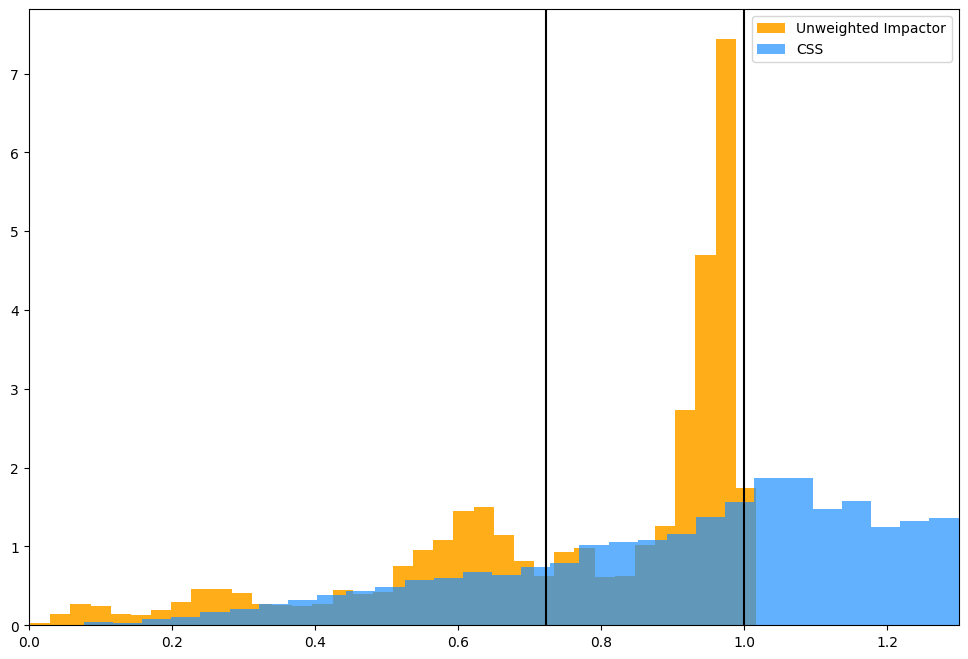

In [11]:
# semi major axes of earth and venus
a_earth = 1.
a_venus = 0.72333199

plt.figure(figsize = (12, 8))
plt.hist(impactor_qs_flat, bins='auto', color = 'orange', label = 'Unweighted Impactor', density=True, alpha=0.9)
plt.hist(mag_limited_qs, bins='auto', color='dodgerblue', label = 'CSS', density=True, alpha=0.7)
# plt.yscale('log')
plt.axvline(a_earth, color = 'k')
plt.axvline(a_venus, color = 'k')
plt.xlim(left=0., right=1.3)
plt.legend()

Compare using a K-S test and find the $p$-value:

In [12]:
import scipy.stats
scipy.stats.ks_2samp(impactor_qs_flat, mag_limited_qs).pvalue

0.0

Now compute weights for each of the impactors from their Opik impact probability, given $a$, $e$ and $i$:

Use the same function for collision probability per revolution in the `monte_carlo_granvik_model.ipynb` notebook:

In [13]:
# constants for earth and sun
a0 = 1.  # semi-major axis of earth in au
m = 5.97e24  # mass of earth in kg
R = 4.259e-5  # radius of earth in au
M = 1.988e30  # mass of sun in kg

# get the probability per revolution P
def get_P(a, e, i, a0=a0, m=m, R=R, M=M):
    """
    Get the collision probability per revolution P for an object with semi-major axis a in AU, eccentricity e, and inclination i in degrees
    and a target on a circular orbit with constant semi-major axis a0 in AU, mass m in kg, and radius R in AU, 
    both orbiting a star with mass M in kg

    return: P, the collision probability per revolution
    """
    Q = R/a0  # Q
    Ux = np.sqrt(2 - (1/a) - (a * (1 - (e ** 2))))  # Ux
    U = np.sqrt(3 - (1/a) - ((2 * np.sqrt(a * (1 - e ** 2))) * np.cos(np.deg2rad(i))))  # U
    tau = Q * np.sqrt(1 + ((2 * m)/(M * Q * (U ** 2))))  # tau
    # tau = R * np.sqrt(1 + R/Q)
    # compute P
    P = ((tau ** 2) * U)/(np.pi * np.sin(np.deg2rad(i)) * np.abs(Ux))
    # return
    return P

Convert the impact probability per revolution $P$ into an impact probability per year $P_t$ :

In [14]:
impactor_pts = np.array([get_P(a, e, i)/(a ** (3./2.)) for a, e, i in zip(impactor_as, impactor_es, impactor_is)])
true_pts = np.array([get_P(a, e, i)/(a ** (3./2.)) for a, e, i in zip(true_as, true_es, true_is)])

impactor_pts_flat = impactor_pts.reshape(-1)

/tmp/ipykernel_80650/1632827845.py:17: RuntimeWarning: invalid value encountered in sqrt
  Ux = np.sqrt(2 - (1/a) - (a * (1 - (e ** 2))))  # Ux
/tmp/ipykernel_80650/3580413378.py:1: RuntimeWarning: invalid value encountered in power
  impactor_pts = np.array([get_P(a, e, i)/(a ** (3./2.)) for a, e, i in zip(impactor_as, impactor_es, impactor_is)])
/tmp/ipykernel_80650/1632827845.py:18: RuntimeWarning: invalid value encountered in sqrt
  U = np.sqrt(3 - (1/a) - ((2 * np.sqrt(a * (1 - e ** 2))) * np.cos(np.deg2rad(i))))  # U


Plot a histogram of the $\log_{10}$ annual impact probability:

(Text(0.5, 0, '$\\log_{10}\\,$impact probability per year'),
 Text(0, 0.5, 'Density'))

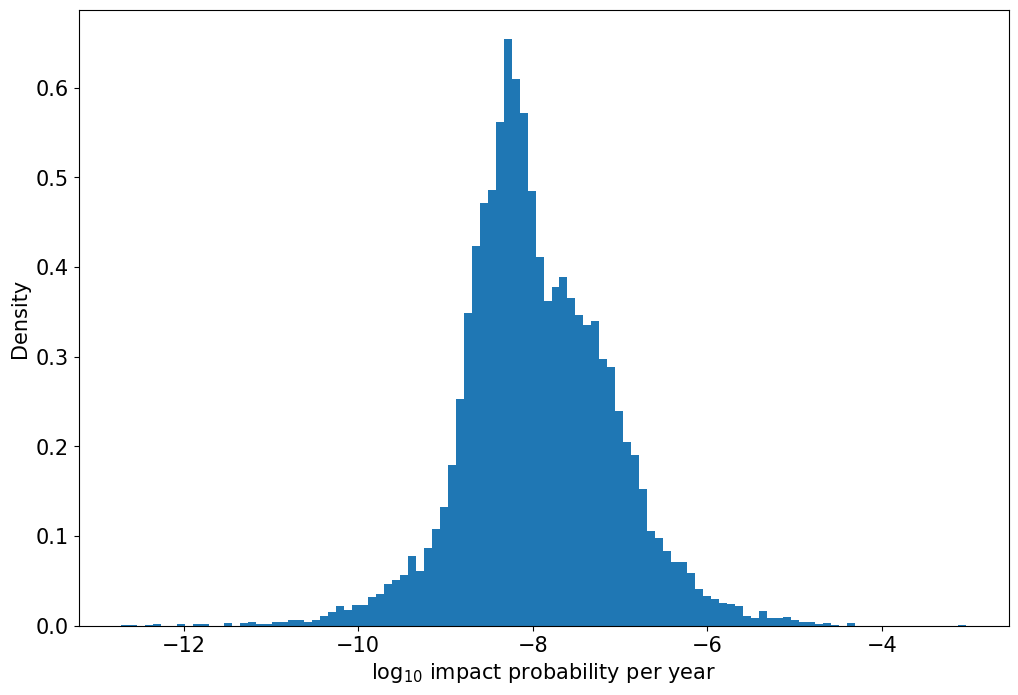

In [15]:
plt.rc('font', size=15)
# convert to lgo to make more readable
plt.figure(figsize = (12, 8))
# plot histogram
plt.hist(np.log10(impactor_pts_flat), bins='auto', density=True)
# label axes
plt.xlabel(r'$\log_{10}\,$impact probability per year'), plt.ylabel('Density')

Eliminate all clones with `nan` annual impact probabilities:

In [16]:
non_nan_mask = ~np.isnan(impactor_pts_flat)  # mask of all non-nan impact probabilities
# filter out nan impact probabilities
impactor_pts_flat_nonnan = impactor_pts_flat[non_nan_mask]
impactor_qs_flat_nonnan = impactor_qs_flat[non_nan_mask]

Define function to filter clones with too low impact probability:

In [17]:
def filter_clones(pts, qs, n_bins=20, lower=0.025, upper=0.975):
    """
    Filters clones with too low impact probability for their respective bin

    Takes as input pts, an array of annual impact probabilities, and qs, an array of corresponding q values

    returns a tuple (pts_filtered, qs_filtered) which are the arrays pts and qs filtered to remove clones with too low impact probability

    n_bins is the number of bins, lower is the lower bound of the confidence interval, upper is the upper bound of the confidence interval
    """
    bin_lbs = np.linspace(0., 1. - 1./n_bins, n_bins)
    # define filtered pts and qs
    pts_filtered = np.array([])
    qs_filtered = np.array([])

    for bin_lb in bin_lbs:
        # generate a mask to filter only for clones within that q bin
        q_mask = (qs > bin_lb) & (qs < (bin_lb + 1./n_bins))
        # get all pt values and q values of clones within that bin
        bin_pts = pts[q_mask]
        bin_qs = qs[q_mask]
        # get 95% quantile of the impact probabilities within that q bin
        ci_lower, ci_upper = np.quantile(bin_pts, q=(lower, upper))
        # now generate a mask to filter only for clones that fall within the 95% quantiles for impact probability
        impact_prob_mask = ((bin_pts > ci_lower) & (bin_pts < ci_upper))
        # finally, apply the impact probability mask to the pt and q values of clones within the q bin
        filtered_bin_pts = bin_pts[impact_prob_mask]
        filtered_bin_qs = bin_qs[impact_prob_mask]
        # and save the qs and probabilities for the bin
        pts_filtered = np.append(pts_filtered, filtered_bin_pts)
        qs_filtered = np.append(qs_filtered, filtered_bin_qs)
        
    # and finally return pts and qs
    return (pts_filtered, qs_filtered)


And try filtering using $20$ bins (a bin size of $0.025$ AU) and plot the differences:

(Text(0.5, 0, 'Annual impact probability'), Text(0, 0.5, 'q'))

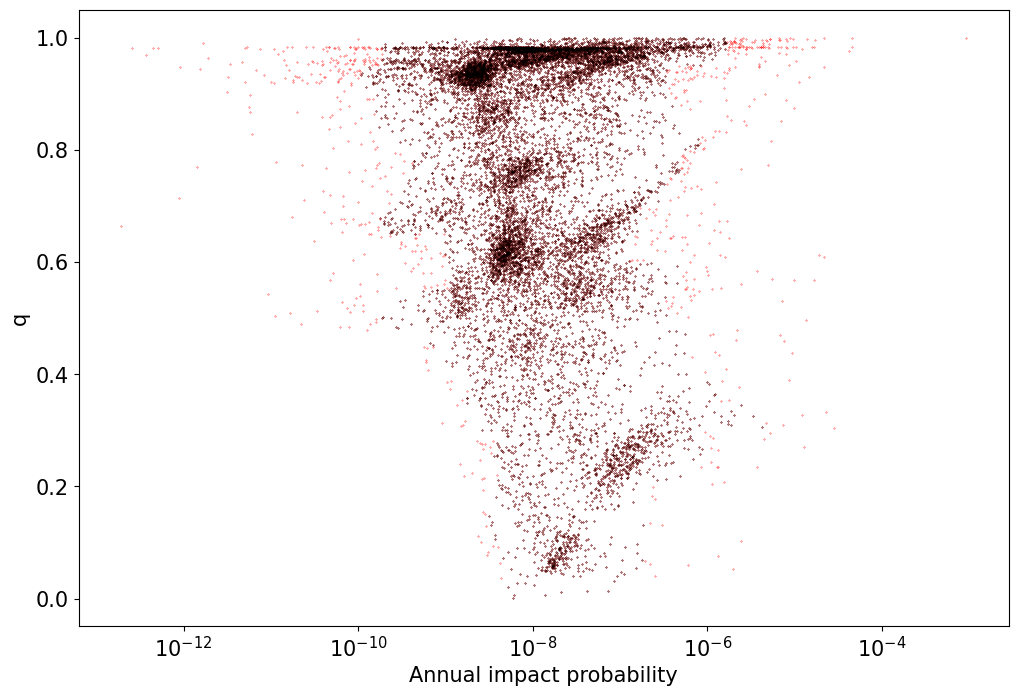

In [18]:
# filter using 20 bins
impactor_pts_flat_filtered, impactor_qs_flat_filtered = filter_clones(impactor_pts_flat_nonnan, impactor_qs_flat_nonnan, n_bins=20)

# PLOTTING:
plt.figure(figsize = (12, 8))
plt.scatter(impactor_pts_flat_nonnan, impactor_qs_flat_nonnan, s=0.07, c='r')
plt.scatter(impactor_pts_flat_filtered, impactor_qs_flat_filtered, s=0.07, c='k')
plt.xscale('log')
plt.xlabel('Annual impact probability'), plt.ylabel('q')

Then plot a histogram comparing the weighted and unweighted filtered $q$ values for the cloned impactors as well as a histogram of the $q$ values for the cloned impactors, weighting by impact probability:

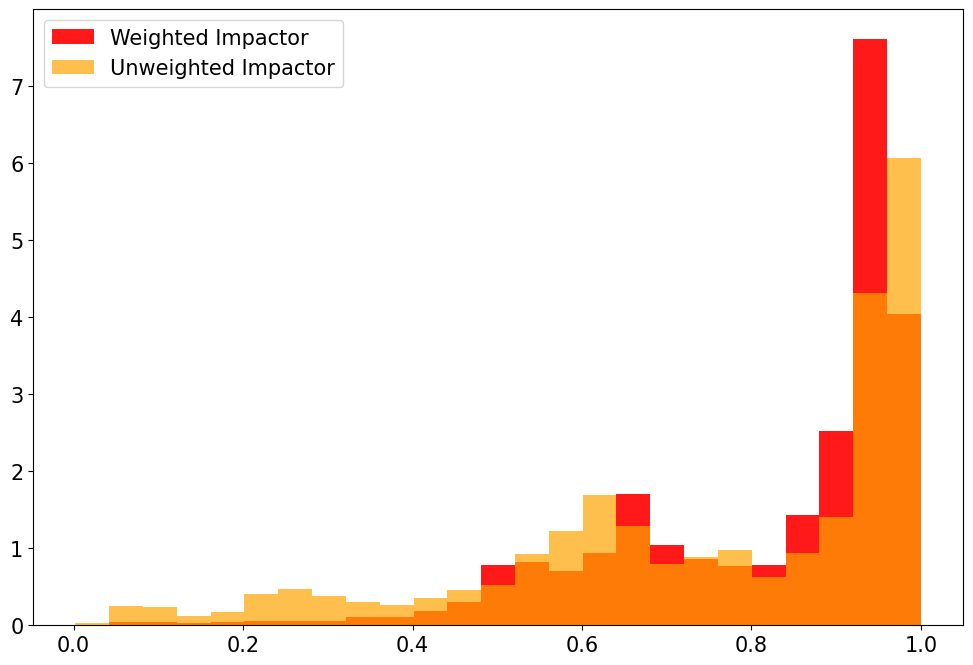

In [19]:
plt.figure(figsize = (12, 8))
plt.hist(impactor_qs_flat_filtered, bins=25, color = 'red', label = 'Weighted Impactor', density=True, 
         weights=1./impactor_pts_flat_filtered, alpha=0.9)
plt.hist(impactor_qs_flat_filtered, bins=25, color = 'orange', label = 'Unweighted Impactor', density=True, 
         weights=None, alpha=0.7)
# plt.yscale('log')
plt.legend()

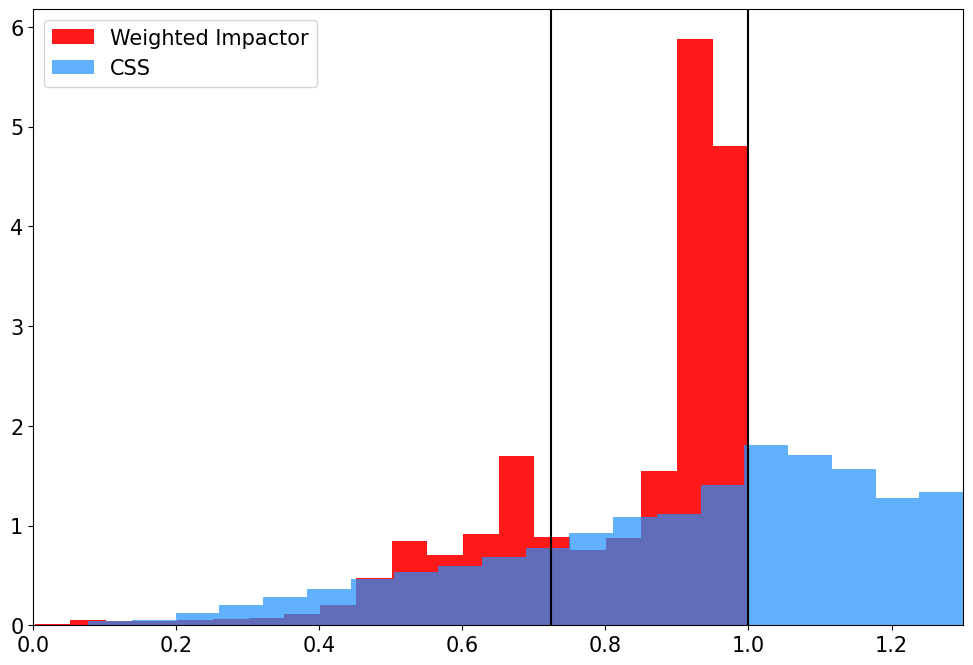

In [20]:
# semi major axes of earth and venus
a_earth = 1.
a_venus = 0.72333199

plt.figure(figsize = (12, 8))
plt.hist(impactor_qs_flat_filtered, bins=20, color = 'red', label = 'Weighted Impactor', density=True, 
         weights=1./impactor_pts_flat_filtered, alpha=0.9)
plt.hist(mag_limited_qs, bins=20, color='dodgerblue', label = 'CSS', density=True, 
         weights=None, alpha=0.7)
# plt.yscale('log')
plt.axvline(a_earth, color = 'k')
plt.axvline(a_venus, color = 'k')
plt.xlim(left=0., right=1.3)
plt.legend()

Weighted K-S test:

In [21]:
from scipy.stats import distributions

def ks_weighted(data1, data2, wei1, wei2, alternative='two-sided'):
    ix1 = np.argsort(data1)
    ix2 = np.argsort(data2)
    data1 = data1[ix1]
    data2 = data2[ix2]
    wei1 = wei1[ix1]
    wei2 = wei2[ix2]
    data = np.concatenate([data1, data2])
    cwei1 = np.hstack([0, np.cumsum(wei1)/sum(wei1)])
    cwei2 = np.hstack([0, np.cumsum(wei2)/sum(wei2)])
    cdf1we = cwei1[np.searchsorted(data1, data, side='right')]
    cdf2we = cwei2[np.searchsorted(data2, data, side='right')]
    d = np.max(np.abs(cdf1we - cdf2we))
    # calculate p-value
    n1 = data1.shape[0]
    n2 = data2.shape[0]
    m, n = sorted([float(n1), float(n2)], reverse=True)
    en = m * n / (m + n)
    if alternative == 'two-sided':
        prob = distributions.kstwo.sf(d, np.round(en))
    else:
        z = np.sqrt(en) * d
        # Use Hodges' suggested approximation Eqn 5.3
        # Requires m to be the larger of (n1, n2)
        expt = -2 * z**2 - 2 * z * (m + 2*n)/np.sqrt(m*n*(m+n))/3.0
        prob = np.exp(expt)
    return d, prob

Computing 1-D K-S test for unweighted and weighted $q$ values and compare unweighted result to default `scipy` K-S test implementation:

In [22]:
print('Unweighted:', ks_weighted(impactor_qs_flat_filtered, np.array(mag_limited_qs), 
                  np.ones(len(impactor_qs_flat_filtered)), np.ones(len(np.array(mag_limited_qs))))) 
print('Weighted:', ks_weighted(impactor_qs_flat_filtered, np.array(mag_limited_qs), 
                  1./impactor_pts_flat_filtered, np.ones(len(np.array(mag_limited_qs)))))

Unweighted: (0.4641998731352409, 0.0)
Weighted: (0.47594443566574063, 0.0)


In [23]:
scipy.stats.ks_2samp(impactor_qs_flat_filtered, mag_limited_qs).statistic, scipy.stats.ks_2samp(impactor_qs_flat_filtered, mag_limited_qs).pvalue

(0.4641998731352409, 0.0)

### Comparing to CNEOS fireballs, 824 EFN fireballs and the EMCCD Meteors:

Read in all the impactors recorded on the CNEOS website and get the state vectors:

In [24]:
# read in cneos fireballs, dropping row if any of time, latitude, longitude, altitude, vx, vy or vz are nan
cneos_fireballs_raw = pd.read_csv('cneos_fireball_data.csv').dropna(subset=['Peak Brightness Date/Time (UT)', 
                                                                            'Latitude (deg.)', 'Longitude (deg.)', 
                                                                            'Altitude (km)', 'vx', 'vy', 'vz'])
# remove decameter-sized impactors
cneos_fireballs_raw = cneos_fireballs_raw[cneos_fireballs_raw['Calculated Total Impact Energy (kt)'] <= 10.]
# 304 fireballs in total

Convert `vx`, `vy`, `vz` to azimuth, zenith and speed and filter out events for which the zenith is not between $0$ and 90$ degrees:

In [25]:
# rtd is constant
rtd = np.pi/180  # rad/deg
# get time, converting to the format used by pylig: '%Y%m%d-%H%M%S.%f'
cneos_t = pd.to_datetime(cneos_fireballs_raw['Peak Brightness Date/Time (UT)'], format='mixed').dt.strftime('%Y%m%d-%H%M%S.%f')
# get elevation
cneos_elevation = cneos_fireballs_raw['Altitude (km)']

# get x, y, z velocities, dropping nans
cneos_vx, cneos_vy, cneos_vz = cneos_fireballs_raw.vx, cneos_fireballs_raw.vy, cneos_fireballs_raw.vz
# convert to numerical long, lat, dropping nans
cneos_latitude = (cneos_fireballs_raw['Latitude (deg.)'].str[:-1].astype(float) * (2 * (cneos_fireballs_raw['Latitude (deg.)'].str[-1:] == 'N') - 1))
cneos_longitude = (cneos_fireballs_raw['Longitude (deg.)'].str[:-1].astype(float) * (2 * (cneos_fireballs_raw['Longitude (deg.)'].str[-1:] == 'E') - 1))

# cneos_vx, cneos_vy, cneos_vz = -10.8, 1.2, -12.8
# cneos_latitude = 59.8
# cneos_longitude = 16.8

# should get 242.771 azim, 16.6202 zen, 16.7905 speed

# get vn, ve, vd from vx, vy, vz and lat, long
cneos_vn = -cneos_vx * np.sin(cneos_latitude * rtd) * np.cos(cneos_longitude * rtd) - cneos_vy * np.sin(cneos_longitude * rtd) * np.sin(cneos_latitude * rtd) + cneos_vz * np.cos(cneos_latitude * rtd)
cneos_ve = -cneos_vx * np.sin(cneos_longitude * rtd) + cneos_vy * np.cos(cneos_longitude * rtd)
cneos_vd = -cneos_vx * np.cos(cneos_latitude * rtd) * np.cos(cneos_longitude * rtd) - cneos_vy * np.cos(cneos_latitude * rtd) * np.sin(cneos_longitude * rtd) - cneos_vz * np.sin(cneos_latitude * rtd)
# get azimuth and zenith
cneos_azim = np.arctan2(cneos_ve, cneos_vn)/rtd + 180.  # NOTE that arctan2 in excel is (x, y) but arctan2 in numpy is (y, x)!
cneos_zen = np.arctan(np.sqrt(cneos_vn ** 2 + cneos_ve ** 2)/cneos_vd)/rtd
# get total velocity
cneos_v = np.sqrt(cneos_vx ** 2 + cneos_vy ** 2 + cneos_vz ** 2)

# filter
zen_mask = (0. < cneos_zen) & (cneos_zen < 90.)  # create mask for zenith between 0 and 90 degrees

# filter v, t, lat, lon, elevation, azim, zenith by the mask
cneos_v = cneos_v[zen_mask]
cneos_t = cneos_t[zen_mask]
cneos_latitude = cneos_latitude[zen_mask]
cneos_longitude = cneos_longitude[zen_mask]
cneos_elevation = cneos_elevation[zen_mask]
cneos_azim = cneos_azim[zen_mask]
cneos_zen = cneos_zen[zen_mask]

Import the calibrated fireball set and compute uncertainties for speed and radiant (this section is copied from `monte_carlo_granvik_model.ipynb`)

In [26]:
# skip the first two rows after header and the last three rows since those are garbage
# note that we want the usg-ground-based-comparison file to be in this form since we are removing absolute rows
usg_ground_based_comparison = pd.read_csv('usg-ground-based-comparison/usg-ground-based-comparison_EDITED.csv', 
                                          sep = ',', skip_blank_lines=True).iloc[2:-3]  

# forward fill Event and radiant, backward fill dv based on the xlsx file
usg_ground_based_comparison['Event'] = usg_ground_based_comparison['Event'].fillna(method='ffill')
usg_ground_based_comparison['Radiant Diff'] = usg_ground_based_comparison['Radiant Diff'].fillna(method='ffill')
usg_ground_based_comparison['DV'] = usg_ground_based_comparison['DV'].fillna(method='bfill')

# drop every other row since we don't need duplicate rows for event, radiant diff, or dv
# however we want to keep the usg reported speed, zenith angle and other parameters (second row for each event), 
# so we start by dropping the first row rather than the second
usg_ground_based_comparison = usg_ground_based_comparison.iloc[1::2]
# strip whitespace from headers to avoid errors with indexing later
usg_ground_based_comparison.columns = usg_ground_based_comparison.columns.str.strip()
# sort dataframe alphabetically inplace
usg_ground_based_comparison.sort_values('Event', inplace=True)

# convert Speed, DV, Radiant Diff, Radiant Zenith Angle, Height, Begin Height, End Height, Length to numeric to avoid errors
cols_to_convert = ['Speed', 'DV', 'Radiant Diff', 'Radiant Zenith Angle', 'Height', 'Begin Height (km)', 'End Height (km)', 'Length (km)']
usg_ground_based_comparison[cols_to_convert] = usg_ground_based_comparison[cols_to_convert].apply(pd.to_numeric, errors='coerce', axis=1)

# convert date to datetime object
usg_ground_based_comparison['Date'] = pd.to_datetime(usg_ground_based_comparison['Date'])

# usg speed, dv, drad
usg_speed = usg_ground_based_comparison['Speed']
# speed and radiant uncertainties
dv = usg_ground_based_comparison['DV']
drad = usg_ground_based_comparison['Radiant Diff']

#### KDES

# Speed

# parameters for the KDE fitting
dv_ub = 8.  # upper bound for fitting kde
dv_lb = -8.  # lower bound for fitting kde
dv_bandwidth = 0.7  # this is finicky  # 0.8 used by default
kernel_type = 'gaussian'  # use gaussian kernel

# setting up the values
values_dv = np.linspace(dv_lb, dv_ub, int(1e4))
kde_dv = np.array(dv).reshape((len(dv), 1))
kde_values_dv = values_dv.reshape(len(values_dv), 1)

# doing the KDE fit
kde_model_dv = KernelDensity(bandwidth=dv_bandwidth, kernel=kernel_type)
kde_model_dv.fit(kde_dv)

# parameters for the KDE fitting
drad_lb = 0.  # upper bound for fitting kde
drad_ub = 2.  # lower bound for fitting kde
log_drad_bandwidth = 0.15  # this is finicky  # 0.15 used by default

# Radiant

# setting up the values
log_drad = np.log10(drad)  # convert to log
values_drad = np.linspace(drad_lb, drad_ub, int(1e4))
kde_log_drad = np.array(log_drad).reshape((len(log_drad), 1))
kde_values_log_drad = values_drad.reshape(len(values_drad), 1)

# kde fit
kde_model_log_drad = KernelDensity(bandwidth=log_drad_bandwidth, kernel=kernel_type)  # use the same kernel as for the dv kde
kde_model_log_drad.fit(kde_log_drad)

/tmp/ipykernel_80650/352979461.py:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  usg_ground_based_comparison['Event'] = usg_ground_based_comparison['Event'].fillna(method='ffill')
/tmp/ipykernel_80650/352979461.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  usg_ground_based_comparison['Radiant Diff'] = usg_ground_based_comparison['Radiant Diff'].fillna(method='ffill')
/tmp/ipykernel_80650/352979461.py:9: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  usg_ground_based_comparison['DV'] = usg_ground_based_comparison['DV'].fillna(method='bfill')


KernelDensity(bandwidth=0.15)

Then for each event, get $100$ Monte Carlo samples, compute the orbital parameters for each Monte Carlo samples, and save it to an array (also copied from `monte_carlo_granvik_model.ipynb`)

In [27]:
import subprocess

# list of orbital parameters we want to get (named the same as in the wmpl output, in that order
orb_param_variables = ['a', 'e', 'i', 'peri', 'node', 'M']  
# number of Monte Carlo samples for each event
n_monte_carlo_samples = 100  # use 100 MC samples

### HELPER FUNCTION to get the zenith/azimuth from the radiant uncertainty
def get_zen_azim_diff(zen, azim, theta, n_samples):
    """
    Get n_samples random new radiants that are a fixed angle theta away from the radiant given by (zen, azim) in 3D
    Note that zenith angle is 90 degrees - azimuth angle

    param zen: zenith angle, in degrees
    param azim: azimuth angle, in degrees
    param theta: angle from radiant that we want our new radiants to be, in degrees
    param n_samples: number of new radiants we want

    return zen_diff, azim_diff: tuple of arrays of floats of size n_samples each: 
    zen_diff and azim_diff are the new randomly generated radiant zenith/azimuth minus the given radiant zenith/azimuth
    """
    new_zens_deg = np.array([np.nan])  # initialize this to get the while loop started

    # this is a while loop to reject any zenith distance above 90 or below 0:
    while not np.all((new_zens_deg > 0.) & (new_zens_deg < 90.)):
        phis = np.random.uniform(0., 2 * np.pi, size=n_samples)  # these are the random directions we want our radiants to be in

        # convert zenith and azimuth into cartesian coordinates x, y, z
        v1 = np.array([np.sin(np.deg2rad(zen)) * np.cos(np.deg2rad(azim)), 
                       np.sin(np.deg2rad(zen)) * np.sin(np.deg2rad(azim)), 
                       np.cos(np.deg2rad(zen))])
        # get random new normalized vectors that are an angle theta away from v1, following the procedure described here:
        # https://math.stackexchange.com/questions/2057315/parameterising-all-vectors-a-fixed-angle-from-another-vector-in-3d
        # standard basis vector to use for generating orthonormal basis
        standard_basis_vec = np.array([1, 0, 0]) 
        # generate two basis vectors orthonormal to v1
        # normalize v1 in case it isn't already
        v1_normed = v1/np.linalg.norm(v1)
        # generate v2
        v2 = np.cross(v1_normed, standard_basis_vec)
        # normalize it
        v2_normed = v2/np.linalg.norm(v2)
        # generate a normalized v3 from the normalized v1 and v2
        v3_normed = np.cross(v1_normed, v2_normed)
        # now generate new vectors with radiant difference scattered by phis using vectorized operations
        new_radiants = v1_normed + np.tan(np.deg2rad(theta)) * (np.multiply.outer(np.cos(phis), v2_normed) + 
                                                                np.multiply.outer(np.sin(phis), v3_normed))
        # normalize the new vectors
        new_radiants_normed = new_radiants/np.linalg.norm(new_radiants, axis=1).reshape(-1, 1)
        # convert from cartesian coordinates back to zenith/azimuth coordinates
        xs, ys, zs = new_radiants_normed.T
        # get zeniths from cartesian
        new_zens = np.arccos(zs)
        # get azimuths from cartesian
        new_azims = np.arcsin(ys/np.sin(new_zens))
        # convert to degrees
        new_zens_deg = np.rad2deg(new_zens)
        new_azims_deg = np.rad2deg(new_azims)
        # first, manually convert the azimuths to the right quadrant since they can range from [0, 2pi] while zeniths can only be [0, pi/2]
        # Q1
        if 0. <= azim <= 90.:
            new_azims_deg = new_azims_deg  # already correct
        # Q2 and Q3:
        if 90. < azim <= 270.:
            new_azims_deg = np.abs(new_azims_deg - 180.)  # convert 
        # Q4:
        if 270. < azim <= 360.:
            new_azims_deg += 360  # convert
        
        # # finally, convert any negative azimuths back to [0, 360] degrees by adding 360 to any values less than 0
        # new_azims_deg += 360 * (new_azims_deg < 0)
        # # and convert any azimuths above 360 back down to [0, 360] as well
        # new_azims_deg = np.mod(new_azims_deg, 360)
            
    # return zenith and azimuth difference
    return new_zens_deg - zen, new_azims_deg - azim


# draw a monte carlo sample and get the orbital parameters using WMPL
def get_monte_carlo_orbital_parameters(kdes_state_vector_params, orb_param_variables=orb_param_variables):
    """
    Samples a Monte Carlo sample from provided KDEs for speed and radiant difference, and gets 
    the orbital parameter values corresponding to each parameter in orb_param_variables from the state vector state_vector
    
    param kdes_state_vector_params: tuple of (dv_kde, drad_kde, v, t, a, o, e, azim, alt):
    dv_kde is the speed uncertainty kde: should be a scikit-learn KernelDensity object
    log_drad_kde is the log10-radiant uncertainty kde: should be a scikit-learn KernelDensity object
    v is the velocity in km/s
    t is the time of the event in the form that the wmpl.Trajectory.Orbit function takes in, '%Y%m%d-%H%M%S.%f'
    a is the latitude, in degrees N
    o is the longitude, in degrees E
    e is the elevation of the event, in km
    azim is the radiant azimuth, in degrees
    zen is the zenith distance (90 minus the altitude angle), in degrees

    returns a 1-D array of parameter values corresponding to the parameters in orb_param_variables, in the same order
    """
    orb_param_array = np.array([])  # initialize orb_param_array as empty array so it doesn't have a size to start

    # unpack kdes and state_vector_params
    dv_kde, log_drad_kde, v, t, a, o, e, azim, zen = kdes_state_vector_params  # get the kdes and state vector parameters
    # converting from zenith angle to altitude angle
    alt = 90 - zen
    
    #### THIS IS A WHILE LOOP AS A SAFEGUARD BECAUSE IT SEEMS LIKE SOMETIMES WMPL DOESN'T RETURN THE ORBITAL ELEMENTS AT ALL
    # so if orbital parameter array is empty (no orbital elements returned) then we repeat this
    while not orb_param_array.size:
        np.random.seed(None)  # explicitly reset the seed since the sampler for sklearn doesn't seem to be sampling randomly otherwise
        # get monte carlo sample of the speed and log-radiant uncertainty
        dv = dv_kde.sample(n_samples=1).flatten()  # get a single dv mc sample
        log_drad = log_drad_kde.sample(n_samples=1).flatten()  # get a single log drad mc sample

        # convert the log-radiant uncertainty into zenith and azimuth uncertainty using the helper function
        # with the restrictions that zenith must be between [0, 90] degrees
        dzen, dazim = get_zen_azim_diff(zen, azim, 10 ** log_drad, n_samples=1)  # log10-radiant so convert back to radiant
        # difference in altitude is negative of difference in zenith since it's 90 - zenith
        # so zen1 - zen2 = (90 - alt1) - (90 - alt2) = alt2 - alt1
        dalt = -dzen
        # adding the uncertainty in velocity to the velocity vector of the event
        # and adding the uncertainty in zenith angle and azimuth angle to the radiant
        # convert the singleton arrays to floats as well
        new_v = v + dv[0]
        new_alt = alt + dalt[0]
        # azimuth is modulo 360 to keep it between 0 and 360 degrees
        new_azim = (azim + dazim[0]) % 360
        # get the output from the wmpl.Trajectory.Orbit script
        output = subprocess.run(['python3', '-m', 'wmpl.Trajectory.Orbit', '-v', f'{new_v}', '-t', f'{t}', '-a', f'{a}', 
                                 '-o', f'{o}', '-e', f'{e}', '--azim', f'{new_azim}', '--alt', f'{new_alt}', 
                                 '--vrotcorr', '--statfixed'], capture_output=True)
        # get the orbital parameters from the output in the order of orb_param_variables
        
        # orb_param_list = [elem for elem in list(map(str.strip, output.stdout.decode('utf-8').split('\n'))) 
        #               if elem.startswith(tuple(orb_param_variables))]
        # orb_param_array = [np.float64(string) for param in orb_param_list 
        #                    for string in param.split() if string.lstrip('-').replace('.', '').isdigit() or string =='nan']]
        
        orb_param_array = np.array([np.float64(string) for param in [elem for elem in 
                                                                     list(map(str.strip, output.stdout.decode('utf-8').split('\n'))) 
                                                                     if elem.startswith(tuple(orb_param_variables))] 
                                    for string in param.split() if string.lstrip('-').replace('.', '').isdigit() or string =='nan'])
    
    # return the orbital parameter array
    return orb_param_array
    

Optional: Run them through Pylig to get the orbital parameter values, using multiprocessing to parallelize it. This takes about $2$ hours to run:

In [28]:
# # define list of all CNEOS state vectors
# cneos_sv_list = list(np.array([cneos_v, cneos_t, cneos_latitude, cneos_longitude, cneos_elevation, cneos_azim, cneos_zen]).T)
# # define array to save the orbital parameters to
# orb_param_array_all_cneos_fireballs = np.zeros((len(cneos_sv_list), n_monte_carlo_samples, len(orb_param_variables)))

# # perform the Monte Carlo cloning and compute the orbital parameters for each cloned state vector
# for i, sv in tqdm(enumerate(cneos_sv_list), total=len(cneos_sv_list)):
#     # unpack
#     v, t, a, o, e, azim, zen = sv
#     # repack with the kde models and repeat 100 times to clone it
#     repacked_sv = np.repeat([[kde_model_dv, kde_model_log_drad, v, t, a, o, e, azim, zen]], n_monte_carlo_samples, axis=0)
#     # now compute orbital parameters from the state vectors for each Monte Carlo sample using multiprocessing:
#     pool = multiprocessing.Pool(multiprocessing.cpu_count() - 1)  # avoids locking up CPU
#     # convert cloned state vectors with orbital parameters
#     orb_param_array_single_cneos_fireball = np.array(list(pool.imap(get_monte_carlo_orbital_parameters, repacked_sv)))
#     # add the orbital parameter array for the single fireball to the array for all fireballs
#     orb_param_array_all_cneos_fireballs[i] = orb_param_array_single_cneos_fireball

Optional: Save file as Numpy array:

In [29]:
# np.save('orb_param_array_all_cneos_fireballs.npy', orb_param_array_all_cneos_fireballs)  # save as a .npy file

Optional: Load file:

In [30]:
orb_param_array_all_cneos_fireballs = np.load('orb_param_array_all_cneos_fireballs.npy')  # load .npy file

Now read in the $824$ EFN fireballs from Borovicka et al. 2022 as well as the EMCCD data:

In [31]:
# Read in EFN fireballs

efn_fireballs = pd.read_fwf('catalog.dat', header=None).drop(columns=[81, 85]) # drop column 81 as well since it's having trouble reading phaethon
efn_fireballs.columns = ['code', 'obs_date', 'obs_time', 'e_obs_time', 'jd', 
                        'lsun', 'lam-beg', 'phi-beg', 'h-beg', 'lam-end', 
                        'phi-end', 'h-end', 'lam-avg', 'phi-avg', 'h-avg', 
                        'lam-max', 'phi-max', 'h-max', 'length', 'dur', 
                        'azim', 'zendis', 'radeg', 'e_radeg', 'dedeg', 
                        'e_dedeg', 'vinf', 'e_vinf', 'vmax', 'vter', 
                        'hvter', 'rageo', 'e_rageo', 'degeo', 'e_degeo', 
                        'lgeo-lsun', 'bgeo', 'vgeo', 'e_vgeo', 'lhel', 
                        'e_lhel', 'bhel', 'e_bhel', 'vhel', 'e_vhel', 
                        'ax', 'e_ax', 'ecc', 'e_ecc', 'perih', 
                        'e_perih', 'aph', 'e_aph', 'inc', 'e_inc', 
                        'omg', 'e_omg', 'nod', 'e_nod', 'lper', 
                        'e_lper', 'tyear', 'tmonth', 'tday', 'e_tday', 
                        'per', 'e_per', 'tiss', 'e_tiss', 'mag', 
                        'energy', 'mass', 'termass', 'pe', 'type', 
                        'pres', 'hpres', 'pf', 'pf-class', 'shower', 
                        'object', 'ncam', 'mindist', 'spectrum']

# Read in EMCCD data

# import kb_and_kc_calc
# emccd_meteors = kb_and_kc_calc.extract_from_table()
emccd_meteors = pd.read_json('solution_table.json')

Get the $a$, $e$, $i$, $q$ values and perform the same impact probability weighting for the CNEOS fireballs, EFN fireballs and the EMCCD data:

In [32]:
# get a, e, i, q for CNEOS fireballs and flatten
cneos_as, cneos_es, cneos_is, cneos_peris, cneos_nodes, cneos_Ms = orb_param_array_all_cneos_fireballs.T
cneos_qs = cneos_as * (1. - cneos_es)
cneos_qs_flat = cneos_qs.reshape(-1)

# for EFN and EMCCD fireballs
efn_as, efn_es, efn_is, efn_qs = np.array(efn_fireballs[['ax', 'ecc', 'inc', 'perih']]).T
emccd_as, emccd_es, emccd_is, emccd_qs = np.array(emccd_meteors[['a', 'e', 'i', 'q']]).T

# and get the CNEOS, EFN and EMCCD annual impact probabilities
cneos_pts = np.array([get_P(a, e, i)/(a ** (3./2.)) for a, e, i in zip(cneos_as, cneos_es, cneos_is)])
efn_pts = np.array([get_P(a, e, i)/(a ** (3./2.)) for a, e, i in zip(efn_as, efn_es, efn_is)])
emccd_pts = np.array([get_P(a, e, i)/(a ** (3./2.)) for a, e, i in zip(emccd_as, emccd_es, emccd_is)])

cneos_pts_flat = cneos_pts.reshape(-1)

/tmp/ipykernel_80650/1632827845.py:17: RuntimeWarning: invalid value encountered in sqrt
  Ux = np.sqrt(2 - (1/a) - (a * (1 - (e ** 2))))  # Ux
/tmp/ipykernel_80650/2685780019.py:11: RuntimeWarning: invalid value encountered in power
  cneos_pts = np.array([get_P(a, e, i)/(a ** (3./2.)) for a, e, i in zip(cneos_as, cneos_es, cneos_is)])
/tmp/ipykernel_80650/1632827845.py:18: RuntimeWarning: invalid value encountered in sqrt
  U = np.sqrt(3 - (1/a) - ((2 * np.sqrt(a * (1 - e ** 2))) * np.cos(np.deg2rad(i))))  # U
/tmp/ipykernel_80650/2685780019.py:12: RuntimeWarning: invalid value encountered in scalar power
  efn_pts = np.array([get_P(a, e, i)/(a ** (3./2.)) for a, e, i in zip(efn_as, efn_es, efn_is)])
/tmp/ipykernel_80650/2685780019.py:13: RuntimeWarning: invalid value encountered in scalar power
  emccd_pts = np.array([get_P(a, e, i)/(a ** (3./2.)) for a, e, i in zip(emccd_as, emccd_es, emccd_is)])


Perform the same filtering for `nan` values and impact probabilities for the CNEOS, EFN and EMCCD data as for the decameter data: 

In [33]:
cneos_non_nan_mask = ~np.isnan(cneos_pts_flat)
efn_non_nan_mask = ~np.isnan(efn_pts)  # mask of all non-nan impact probabilities
emccd_non_nan_mask = ~np.isnan(emccd_pts)

# filter out nan impact probabilities from flat CNEOS, EFN and EMCCD data
cneos_pts_nonnan = cneos_pts_flat[cneos_non_nan_mask]
cneos_qs_nonnan = cneos_qs_flat[cneos_non_nan_mask]

efn_pts_nonnan = efn_pts[efn_non_nan_mask]
efn_qs_nonnan = efn_qs[efn_non_nan_mask]

emccd_pts_nonnan = emccd_pts[emccd_non_nan_mask]
emccd_qs_nonnan = emccd_qs[emccd_non_nan_mask]

# filter impact probabilities using 20 bins
cneos_pts_filtered, cneos_qs_filtered = filter_clones(cneos_pts_nonnan, cneos_qs_nonnan, n_bins=20)
efn_pts_filtered, efn_qs_filtered = filter_clones(efn_pts_nonnan, efn_qs_nonnan, n_bins=12, lower=0.05, upper=0.95)  # fiddle with this, it's tough to make this work...
emccd_pts_filtered, emccd_qs_filtered = filter_clones(emccd_pts_nonnan, emccd_qs_nonnan, n_bins=20)

Plot probabilities:

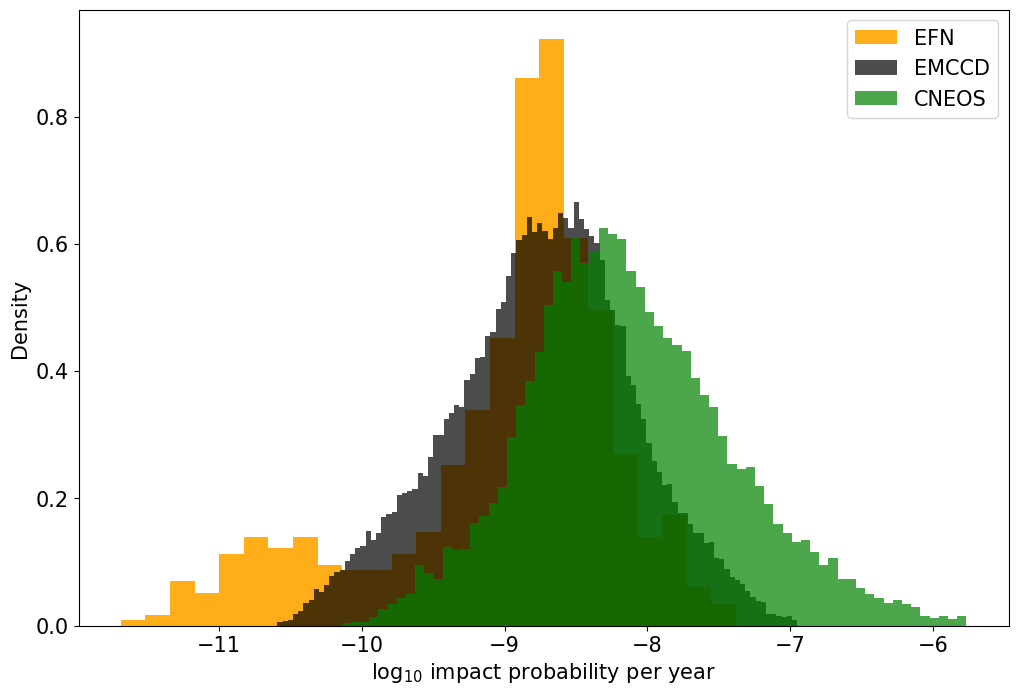

In [34]:
plt.rc('font', size=15)
# convert to lgo to make more readable
plt.figure(figsize = (12, 8))
# plot histogram
plt.hist(np.log10(efn_pts_filtered), bins='auto', density=True, label = 'EFN', color='orange', alpha=0.9)
plt.hist(np.log10(emccd_pts_filtered), bins='auto', density=True, label = 'EMCCD', color='black', alpha=0.7)
plt.hist(np.log10(cneos_pts_filtered), bins='auto', density=True, label = 'CNEOS', color='green', alpha=0.7)
# label axes
plt.xlabel(r'$\log_{10}\,$impact probability per year'), plt.ylabel('Density')
plt.legend()

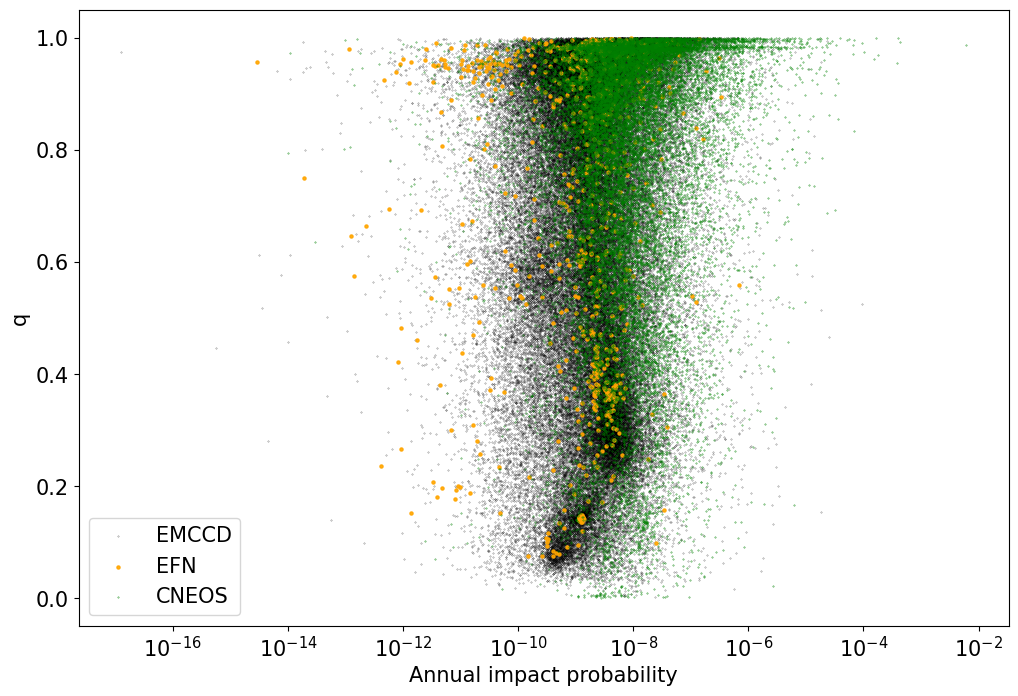

In [35]:
plt.figure(figsize = (12, 8))
plt.scatter(emccd_pts, emccd_qs, s=0.07, c='black', label = 'EMCCD', alpha=0.6)
plt.scatter(efn_pts, efn_qs, s=5, c='orange', label = 'EFN', alpha=0.9)
plt.scatter(cneos_pts, cneos_qs, s=0.1, c='green', label = 'CNEOS', alpha = 0.9)
plt.xscale('log')
plt.xlabel('Annual impact probability'), plt.ylabel('q')
plt.legend()

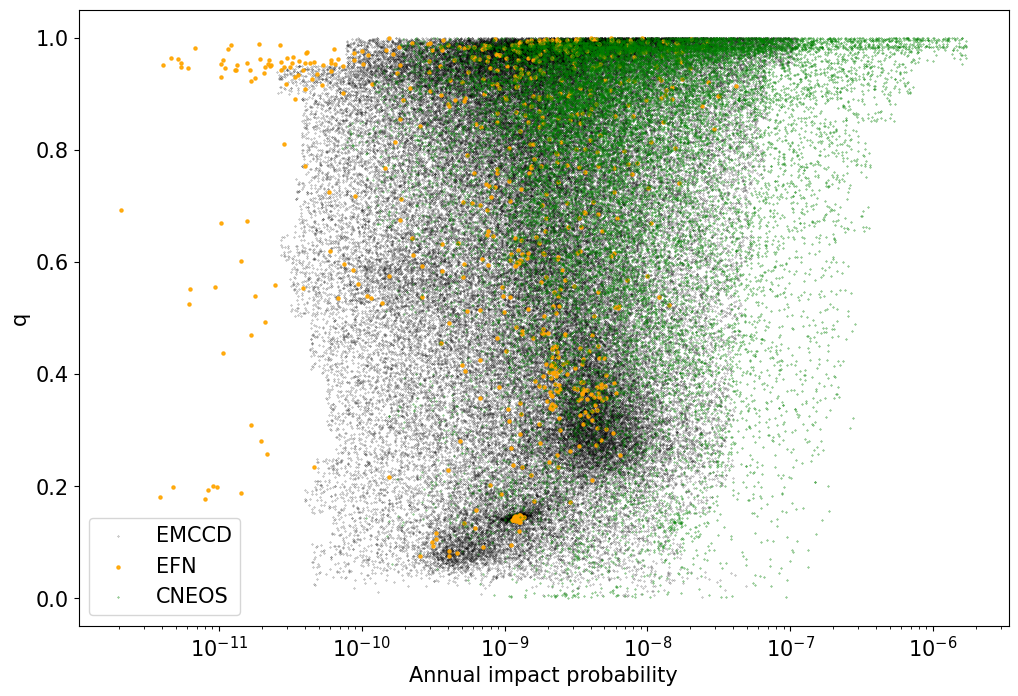

In [36]:
plt.figure(figsize = (12, 8))
plt.scatter(emccd_pts_filtered, emccd_qs_filtered, s=0.07, c='black', label = 'EMCCD', alpha=0.6)
plt.scatter(efn_pts_filtered, efn_qs_filtered, s=5, c='orange', label = 'EFN', alpha=0.9)
plt.scatter(cneos_pts_filtered, cneos_qs_filtered, s=0.1, c='green', label = 'CNEOS', alpha = 0.9)
plt.xscale('log')
plt.xlabel('Annual impact probability'), plt.ylabel('q')
plt.legend()

And plot a histogram of the CSS observations against the weighted decameter impactors, weighted CNEOS fireballs, weighted EFN fireballs, weighted EMCCD meteors

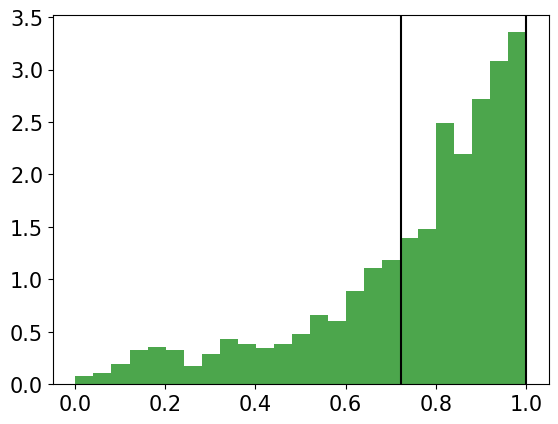

In [37]:
plt.hist(cneos_qs_filtered, bins=25, color='green', label = 'Weighted CNEOS', density=True, 
         weights=1./cneos_pts_filtered, alpha=0.7)
plt.axvline(a_earth, color='k')
plt.axvline(a_venus, color='k')

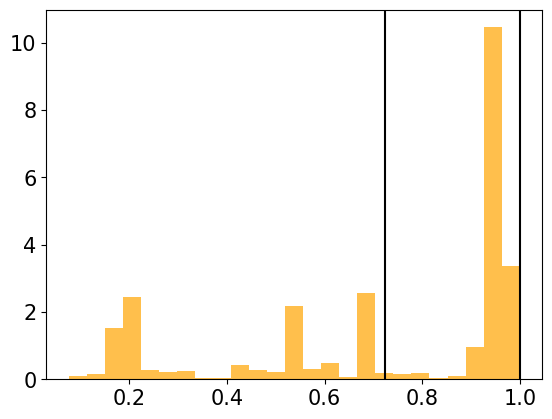

In [38]:
plt.hist(efn_qs_filtered, bins=25, color='orange', label = 'Weighted EFN', density=True, 
         weights=1./efn_pts_filtered, alpha=0.7)
plt.axvline(a_earth, color='k')
plt.axvline(a_venus, color='k')

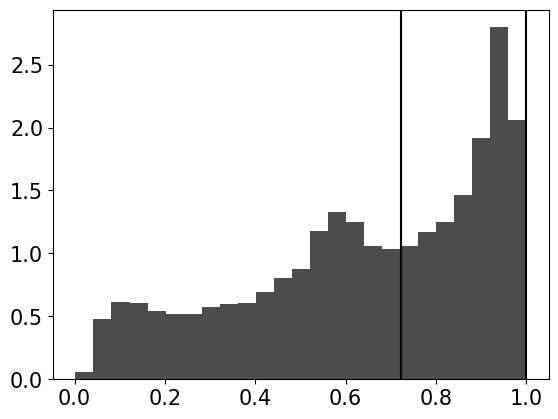

In [39]:
plt.hist(emccd_qs_filtered, bins=25, color='black', label = 'Weighted EMCCD', density=True, 
         weights=1./emccd_pts_filtered, alpha=0.7)
plt.axvline(a_earth, color='k')
plt.axvline(a_venus, color='k')

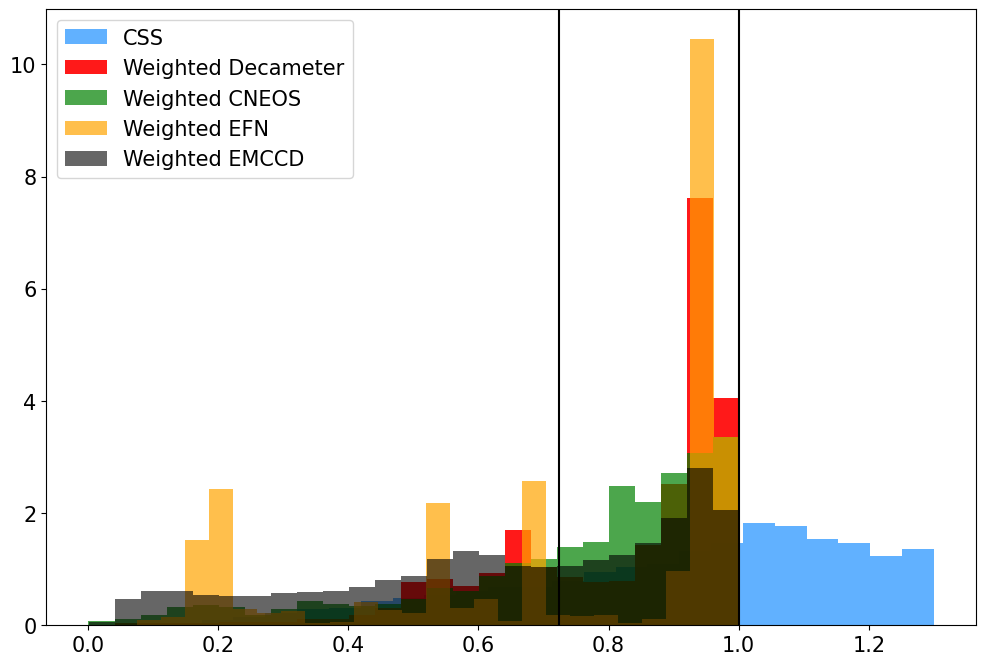

In [40]:
plt.figure(figsize = (12, 8))
# CSS
plt.hist(mag_limited_qs, bins=25, color='dodgerblue', label = 'CSS', density=True, 
         weights=None, alpha=0.7)
# Decameter impactors
plt.hist(impactor_qs_flat_filtered, bins=25, color = 'red', label = 'Weighted Decameter', density=True, 
         weights=1./impactor_pts_flat_filtered, alpha=0.9)
# CNEOS Fireballs
# plt.hist(cneos_qs[cneos_non_nan_mask], bins=25, color='green', label = 'Unweighted CNEOS Fireballs', density=True, alpha=0.7)
plt.hist(cneos_qs_filtered, bins=25, color='green', label = 'Weighted CNEOS', density=True, 
         weights=1./cneos_pts_filtered, alpha=0.7)
# EFN Fireballs
# plt.hist(efn_qs[efn_non_nan_mask], bins=25, color='green', label = 'Unweighted EFNFireballs', density=True, alpha=0.7)
plt.hist(efn_qs_filtered, bins=25, color = 'orange', label = 'Weighted EFN', density=True, 
         weights=1./efn_pts_filtered, alpha=0.7)
# EMCCD Meteors
# plt.hist(emccd_qs[emccd_non_nan_mask], bins=25, color='green', label = 'Unweighted EMCCD Meteors', density=True)
plt.hist(emccd_qs_filtered, bins=25, color = 'black', label = 'Weighted EMCCD', density=True, 
         weights=1./emccd_pts_filtered, alpha=0.6)

# plt.yscale('log')
plt.legend()
plt.axvline(a_earth, color = 'k')
plt.axvline(a_venus, color = 'k')

In [41]:
len(mag_limited_qs), len(impactor_qs_flat_filtered), len(cneos_qs_filtered), len(efn_qs_filtered), len(emccd_qs_filtered)

(5568, 12032, 23479, 667, 98913)